In [1]:
# https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html
#  python libraries in data science
# ==============================================================================
import pandas as pd
import numpy as np

# Plotting
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocessing y modeling
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

In [2]:
# matplotlib setup
# ==============================================================================
plt.rcParams['image.cmap'] = "RdBu"
plt.rcParams['figure.dpi'] = "90"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['figure.figsize'] = (9, 6)
style.use('ggplot') or plt.style.use('ggplot')

#  warnings 
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Input Data
# ==============================================================================
datos = pd.read_csv('Data/meatspec.csv')
datos = datos.drop(columns = datos.columns[0]) # dropping allnon real-valued data
print(datos.head())
print('dimension ',datos.shape)

        V2       V3       V4       V5       V6       V7       V8       V9  \
0  2.61814  2.61859  2.61912  2.61981  2.62071  2.62186  2.62334  2.62511   
1  2.83871  2.84283  2.84705  2.85138  2.85587  2.86060  2.86566  2.87093   
2  2.58458  2.58629  2.58808  2.58996  2.59192  2.59401  2.59627  2.59873   
3  2.82460  2.82630  2.82814  2.83001  2.83192  2.83392  2.83606  2.83842   
4  2.78989  2.79167  2.79350  2.79538  2.79746  2.79984  2.80254  2.80553   

       V10      V11  ...      V92      V93      V94      V95      V96  \
0  2.62722  2.62964  ...  2.98145  2.96072  2.94013  2.91978  2.89966   
1  2.87661  2.88264  ...  3.29186  3.27921  3.26655  3.25369  3.24045   
2  2.60131  2.60414  ...  2.68951  2.67009  2.65112  2.63262  2.61461   
3  2.84097  2.84374  ...  2.97367  2.94951  2.92576  2.90251  2.87988   
4  2.80890  2.81272  ...  3.30025  3.27907  3.25831  3.23784  3.21765   

       V97      V98      V99     V100   fat  
0  2.87964  2.85960  2.83940  2.81920  22.5  
1  3.2

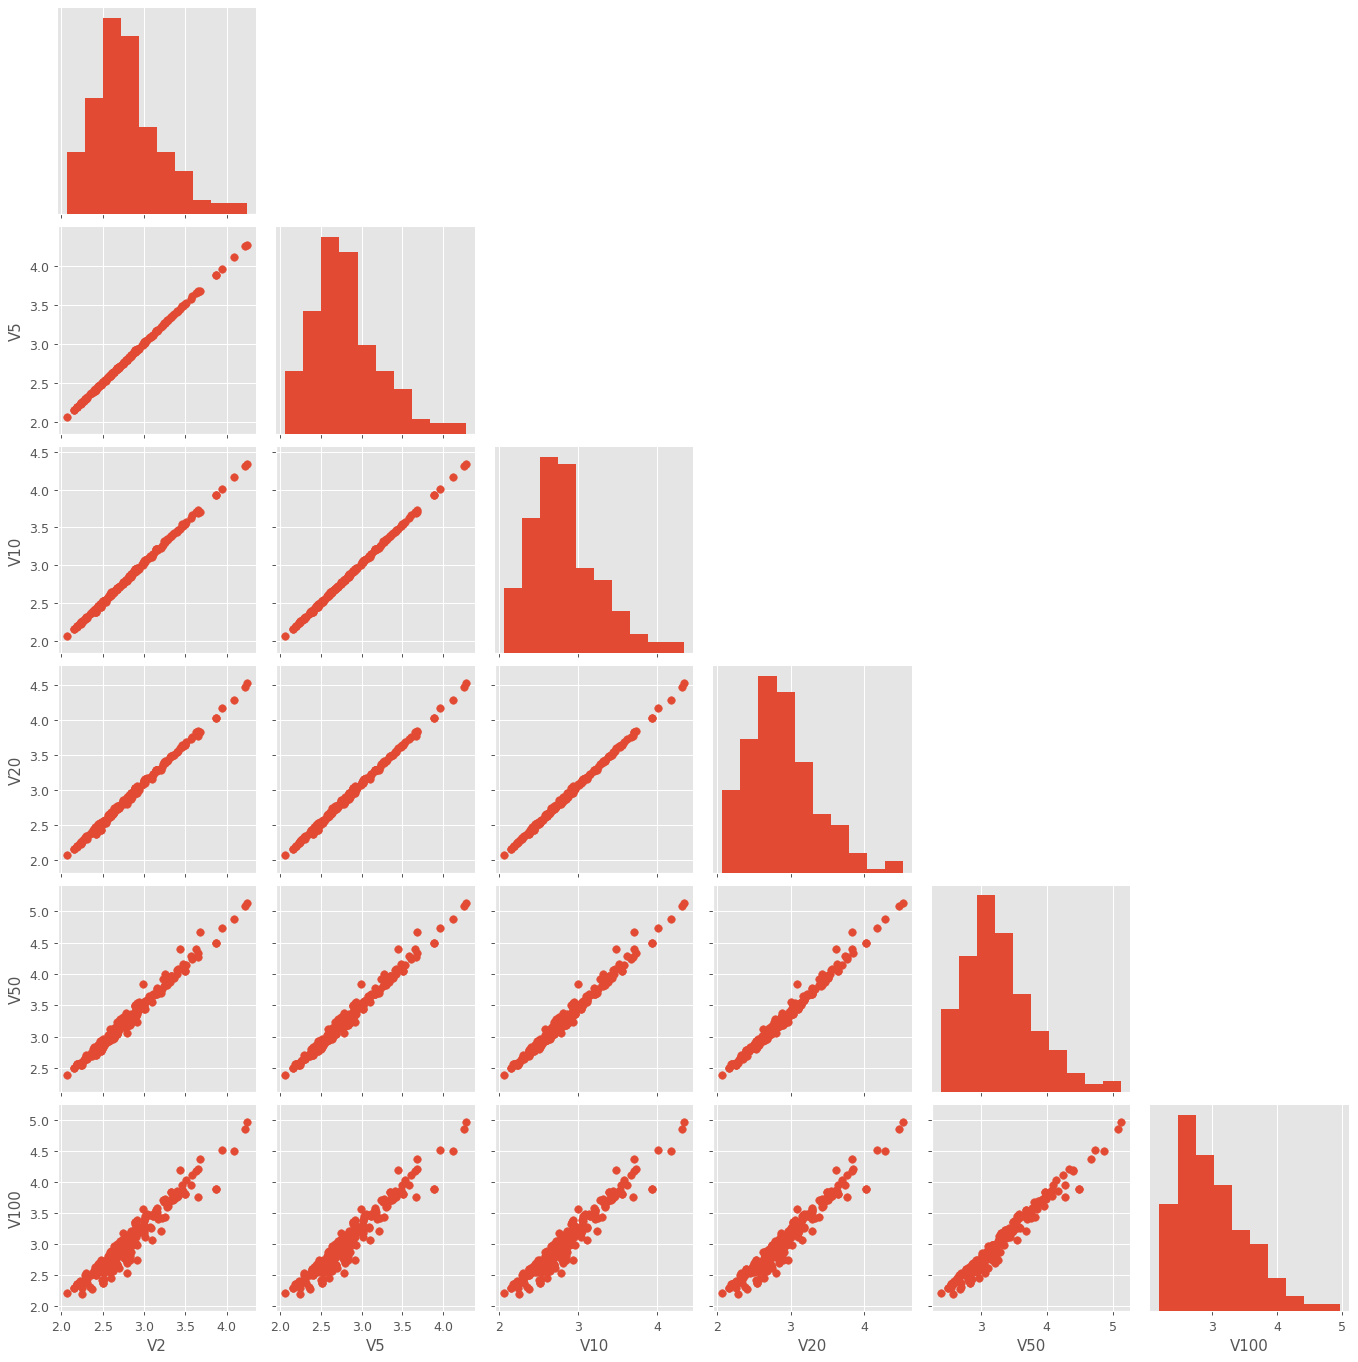

In [4]:
#   scatterplot of few features
 
def better_scatter(x, y, **kwargs):
    plt.scatter(x, y, **kwargs)
    margin = (max(y) - min(y)) * 0.1
    plt.ylim(min(y) - margin, max(y) + margin)

df = datos[['V2', 'V5','V10', 'V20','V50','V100']].dropna()
    
g = sns.PairGrid(df,  diag_sharey=False, corner=True)
g = g.map_diag(plt.hist)
g = g.map_offdiag(better_scatter)


In [5]:
# Correlation between real-valued columns
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    Tidy datasets are easy to manipulate, model and visualize, and 
    have a specific structure: each variable is a column, each observation is a row, and each type of observational unit is a table
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = datos.select_dtypes(include=['float64', 'int']) \
              .corr(method='pearson')
display(tidy_corr_matrix(corr_matrix).head(5))

,variable_1,variable_2,r,abs_r
908,V11,V10,0.999996,0.999996
809,V10,V11,0.999996,0.999996
1009,V12,V11,0.999996,0.999996
910,V11,V12,0.999996,0.999996
807,V10,V9,0.999996,0.999996


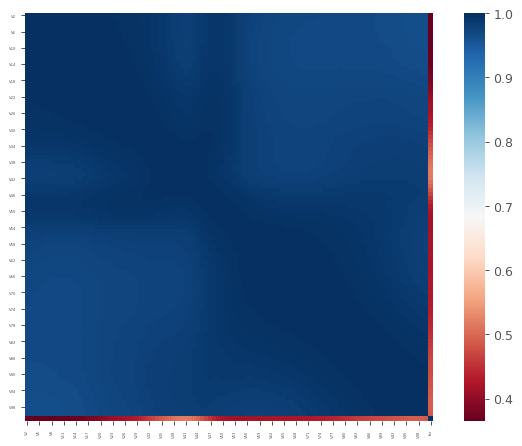

In [6]:
# Heatmap correlation matrix
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1)

sns.heatmap(
    corr_matrix,
    cmap="RdBu",
    square    = True,
    ax        = ax
)

ax.tick_params(labelsize = 3)


In [7]:
# Splitting data in train  and test  sets
# ==============================================================================
X = datos.drop(columns='fat')
y = datos['fat']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

### Ordinary Least Squares

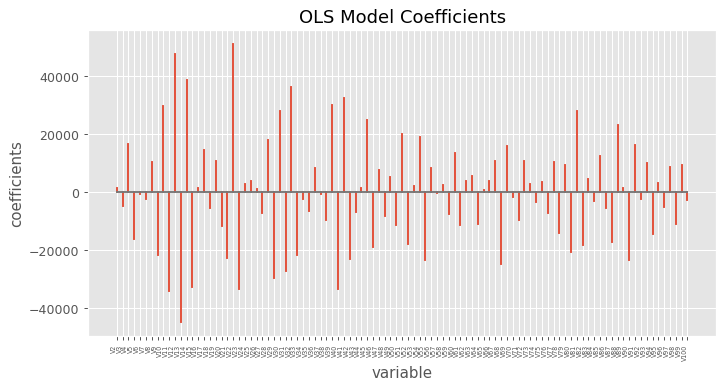

In [8]:
# Building and training of the [Linear] model 
# ==============================================================================
modelo = LinearRegression(normalize=True)
modelo.fit(X = X_train, y = y_train)

# Estimated model coefficients
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(9, 4.5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coefficients')
ax.set_title('OLS Model Coefficients');

In [9]:
# Prediction test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([39.06822356, 56.38917472, 64.14900104,  9.76230811, 17.83618923,
        6.75968654, 29.2960073 ,  8.95645047, 15.44537657, 16.65795682])

In [10]:
# Error of testing model 
# ==============================================================================
rmse_ols = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_ols}")


El error (rmse) de test es: 3.91153830095864


## Ridge

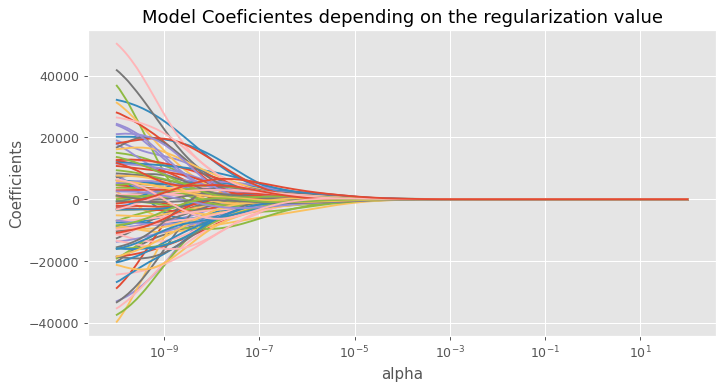

In [11]:
# Building and training of the [Ridge] model  (including searching of optimal alpha  through CV)
# ==============================================================================
#  RidgeCV uses, by deafult,  the mean squared error
modelo = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            normalize       = True,
            store_cv_values = True
         )

_ = modelo.fit(X = X_train, y = y_train)

# Evolution of coeficients depending on alpha
# ==============================================================================
alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('Coefficients')
ax.set_title('Model Coeficientes depending on the regularization value');
plt.axis('tight')
plt.show()

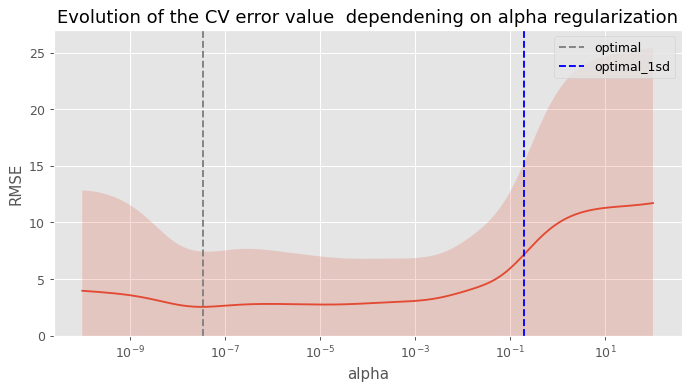

In [12]:
# Evolution of coeficients depending on  alpha
# ==============================================================================
# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_samples, n_targets, n_alphas)
mse_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(modelo.alphas, rmse_cv)
ax.fill_between(
    modelo.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'optimal'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'optimal_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolution of the CV error value  dependening on alpha regularization')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();


In [13]:
# The best value estimated for alpha
# ==============================================================================
print(f"The best value estimated for alpha: {modelo.alpha_}")

The best value estimated for alpha: 3.4092850697468076e-08


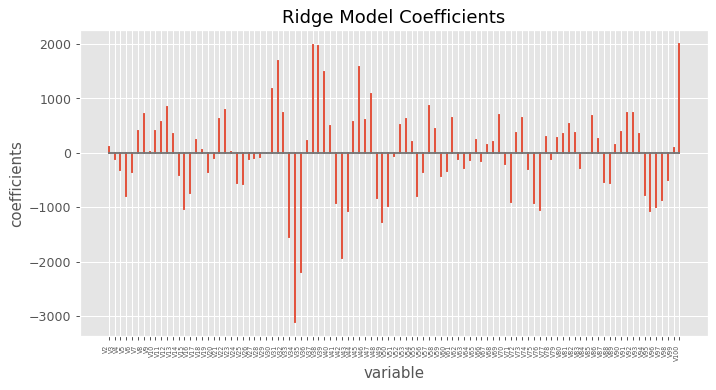

In [14]:
# RIGDE Model Coefficients  
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(9, 4.5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coefficients')
ax.set_title('Ridge Model Coefficients');

In [15]:
# Predicction test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([43.35143549, 40.82605408, 51.14221331,  9.94880836, 17.91960999,
        7.7164198 , 28.20620923,  8.2221912 , 14.8432898 , 14.43898846])

In [16]:
# Error de test del modelo 
# ==============================================================================
rmse_ridge = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
             )
print("")
print(f"El error (rmse) de test es: {rmse_ridge}")


El error (rmse) de test es: 2.395513464397673


## Lasso

In [17]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto LassoCV utiliza el mean squared error
modelo = LassoCV(
            alphas          = np.logspace(-10, 3, 200),
            normalize       = True,
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train)

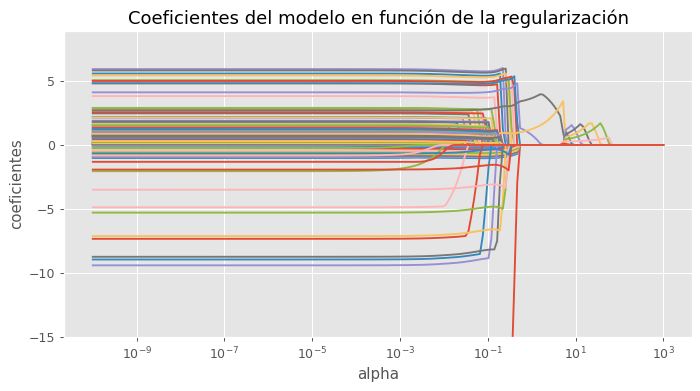

In [18]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');

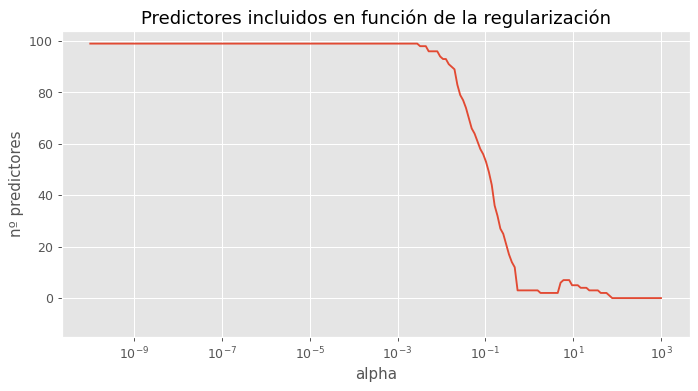

In [19]:
# Número de predictores incluidos (coeficiente !=0) en función de alpha
# ==============================================================================
alphas = modelo.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización');

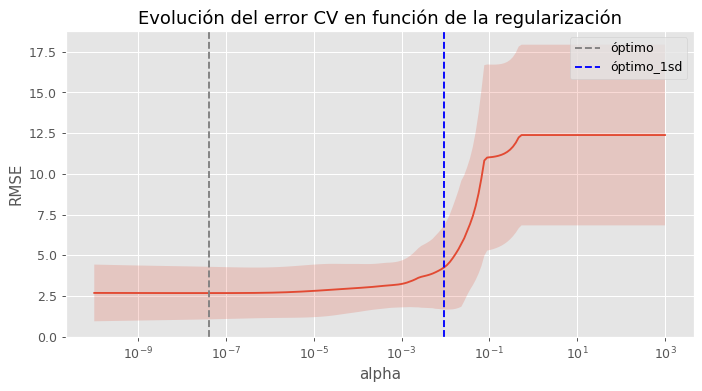

In [20]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_alphas, n_folds)
mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(
    modelo.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [21]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 4.1026581058271906e-08


In [22]:
# Mejor valor alpha encontrado + 1sd
# ==============================================================================
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_1sd}")

Mejor valor de alpha encontrado + 1 desviación estándar: [0.0093293]


In [23]:
# Mejor modelo alpha óptimo + 1sd
# ==============================================================================
modelo = Lasso(alpha=optimo_1sd, normalize=True)
modelo.fit(X_train, y_train)

Lasso(alpha=array([0.0093293]), normalize=True)

In [24]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
5,V7,-3.766799
6,V8,-19.022948
7,V9,-17.046360
8,V10,-14.661111
9,V11,-12.697650
10,V12,-10.718818
11,V13,-8.715138
12,V14,-6.577317
13,V15,-4.518882
14,V16,-2.644992


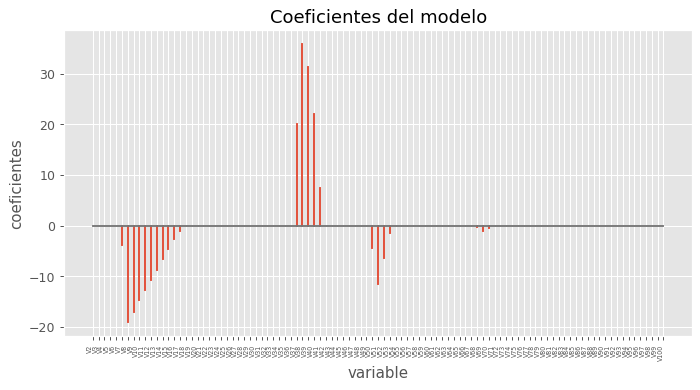

In [25]:
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [26]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([33.81256717, 52.74703313, 35.5471588 , 12.16311461, 15.15159868,
        6.47947406, 24.29350134,  7.53196766, 13.70492965, 19.14565604])

In [27]:
# Error de test del modelo 
# ==============================================================================
rmse_lasso = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
             )
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 3.954949765030586


## Elastic Net

In [28]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto ElasticNetCV utiliza el mean squared error
modelo = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            normalize       = True,
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train)

In [29]:
# Evolución del error en función de alpha y l1_ratio
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha y l1_ratio.
# Tiene dimensiones (n_l1_ratio, n_alpha, n_folds)
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = modelo.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [modelo.l1_ratio, modelo.alphas_],
                                    names     = ['l1_ratio', 'modelo.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,modelo.alphas_,mse_cv,rmse_cv
977,0.90,2.736440e-09,7.175413,2.678696
978,0.90,2.354286e-09,7.175441,2.678701
785,0.70,8.214344e-10,7.175597,2.678731
784,0.70,9.547716e-10,7.175629,2.678736
976,0.90,3.180626e-09,7.175651,2.678741
...,...,...,...,...
1209,0.99,2.582619e+02,153.287425,12.380930
1208,0.99,3.001836e+02,153.287425,12.380930
1207,0.99,3.489101e+02,153.287425,12.380930
1213,0.99,1.414991e+02,153.287425,12.380930


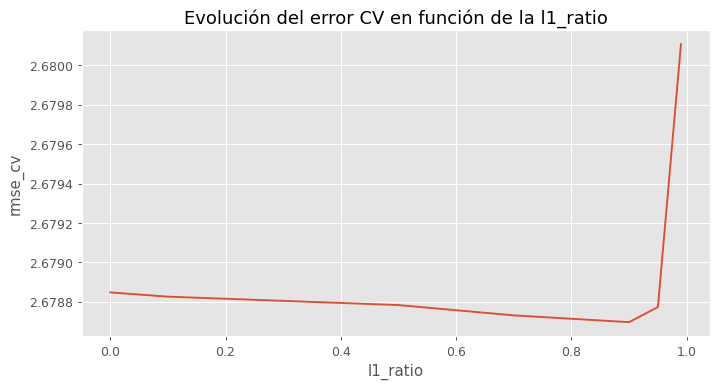

In [30]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(9, 4.5))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [31]:
# Mejor valor alpha y l1_ratio_ encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo.l1_ratio_}")

Mejor valor de alpha encontrado: 2.7364399970746664e-09
Mejor valor de l1_ratio encontrado: 0.9


In [32]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

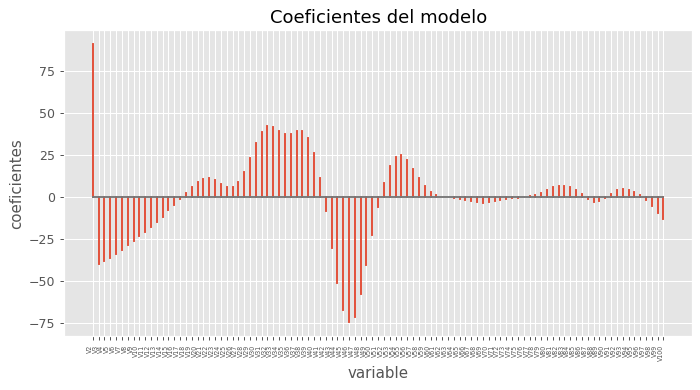

In [33]:
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [34]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()

In [35]:
# Error de test del modelo 
# ==============================================================================
rmse_elastic = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
               )
print("")
print(f"El error (rmse) de test es: {rmse_elastic}")


El error (rmse) de test es: 5.318388286968955


## Comparación

In [ ]:
df_comparacion = pd.DataFrame({
                    'modelo': ['OLS', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(9, 4.5))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

In [ ]:
!pip install sinfo

warnings.filterwarnings('ignore')

In [ ]:
from sinfo import sinfo
sinfo()

## literature
- https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html